<a href="https://colab.research.google.com/github/NahinAlam001/CSE-465/blob/master/PCOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
import torch
from torch import nn

print(torch.__version__)

2.2.1+cu121


In [212]:
# device = "cuda" if torch.cuda.is_available else "cpu"
device = 'cpu'
print(device)

cpu


In [181]:
from math import e
from pathlib import Path

data_path = Path('data/')
image_path = data_path/'images'

if image_path.is_dir():
  print(f'{image_path} does not exist... Skipping Folder Creation')
else:
  print(f'{image_path} does exist... Creating Folder')
  image_path.mkdir(parents=True, exist_ok=True)

data/images does not exist... Skipping Folder Creation


In [182]:
import gdown

gdown.download('https://drive.google.com/uc?export=download&id=10tPq2ERw3NHQWLsia3hnBb1Yc54dJwS8', 'images.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=10tPq2ERw3NHQWLsia3hnBb1Yc54dJwS8
From (redirected): https://drive.google.com/uc?export=download&id=10tPq2ERw3NHQWLsia3hnBb1Yc54dJwS8&confirm=t&uuid=217b8b70-cc64-4ee0-a623-5d0f9cdba853
To: /content/images.zip
100%|██████████| 132M/132M [00:00<00:00, 191MB/s]


'images.zip'

In [183]:
import zipfile

with zipfile.ZipFile('images.zip', 'r') as zip_ref:
  zip_ref.extractall()

print(f'Extracted files')

Extracted files


In [184]:
# Define the destination directory
source_dirs = ['/content/data/test','/content/data/train']
destination_dir = '/content/data/images'

for directory in source_dirs:
  !mv {directory} {destination_dir}/

mv: cannot move '/content/data/test' to '/content/data/images/test': Directory not empty
mv: cannot move '/content/data/train' to '/content/data/images/train': Directory not empty


In [185]:
import os

def walk_through_dir(dir_path):
  '''Walks through directories and prints the number of pictures in them'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} pictures in {dirpath}')

walk_through_dir(image_path)

There are 2 directories and 0 pictures in data/images
There are 2 directories and 0 pictures in data/images/test
There are 0 directories and 787 pictures in data/images/test/infected
There are 0 directories and 1145 pictures in data/images/test/notinfected
There are 2 directories and 0 pictures in data/images/train
There are 0 directories and 781 pictures in data/images/train/infected
There are 0 directories and 1143 pictures in data/images/train/notinfected


In [186]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
len(image_path_list)

3846

Class: infected | Size: (300, 300)


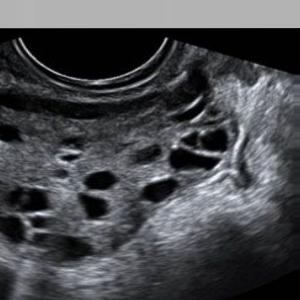

In [187]:
import random
from PIL import Image

random.seed(42)

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f'Class: {image_class} | Size: {img.size}')
img

(-0.5, 299.5, 299.5, -0.5)

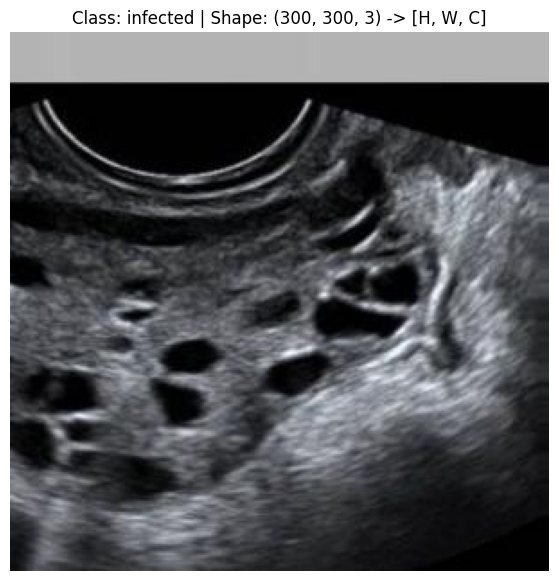

In [188]:
import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f'Class: {image_class} | Shape: {image_as_array.shape} -> [H, W, C]')
plt.axis(False)

In [189]:
from torchvision import transforms

data_transform = transforms.Compose([
  transforms.Resize(size=(64,64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

In [190]:
data_transform(img).dtype

torch.float32

In [191]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n = 3,
                            seed = None):
  '''
    Selects random images from a path of images and loads/transforms them. Plots the orginal vs the transformed version
  '''
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k= n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class:{image_path.parent.stem}', fontsize=16)

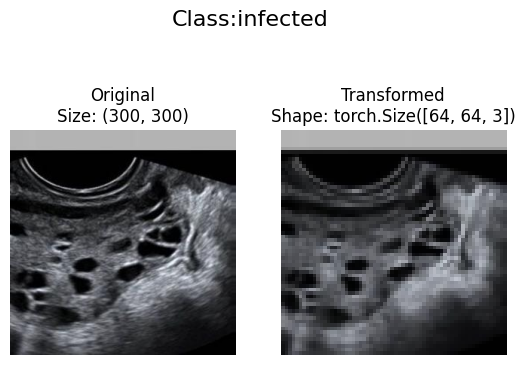

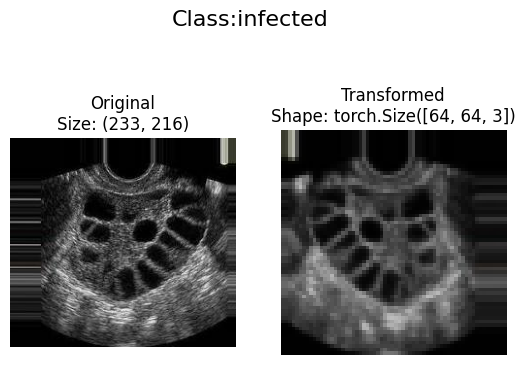

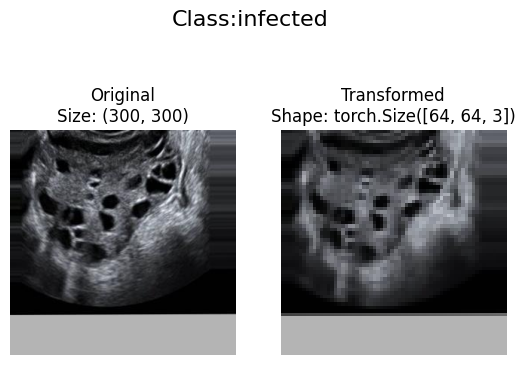

In [192]:
plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n = 3,
                        seed = 42)

In [193]:
train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir, test_dir

(PosixPath('data/images/train'), PosixPath('data/images/test'))

In [194]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1924
     Root location: data/images/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1932
     Root location: data/images/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [195]:
class_names = train_data.classes
print(class_names)

['infected', 'notinfected']


In [196]:
class_dict = train_data.class_to_idx
print(class_dict)

{'infected': 0, 'notinfected': 1}


In [197]:
len(train_data), len(test_data)

(1924, 1932)

In [198]:
train_data.samples[0]

('data/images/train/infected/img1.jpg', 0)

In [199]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor: {img}\nImage Shape: {img.shape} | Image dtype: {img.dtype}\nImage Label: {label} | Label dtype: {type(label)}')

Image Tensor: tensor([[[0.4078, 0.4078, 0.4078,  ..., 0.4078, 0.4078, 0.4078],
         [0.1725, 0.1725, 0.1725,  ..., 0.1725, 0.1725, 0.1725],
         [0.1765, 0.1765, 0.1765,  ..., 0.1765, 0.1765, 0.1765],
         ...,
         [0.1373, 0.1373, 0.1373,  ..., 0.1373, 0.1373, 0.1373],
         [0.1373, 0.1373, 0.1373,  ..., 0.1373, 0.1373, 0.1373],
         [0.2392, 0.2392, 0.2392,  ..., 0.2392, 0.2392, 0.2392]],

        [[0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
         [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1529, 0.1529, 0.1529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314]],

        [[0.4039, 0.4039, 0.4039,  ..., 0.4039, 0.4039, 0.4039],
         [0.1608, 0.1608, 0.1608,  ..., 0.1608, 0.1608, 0.1608],
         [0.1608, 0.1608, 0.1608,  ..., 0.16

Orginal Shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image Permuted: torch.Size([64, 64, 3]) -> [H, W, C]


(-0.5, 63.5, 63.5, -0.5)

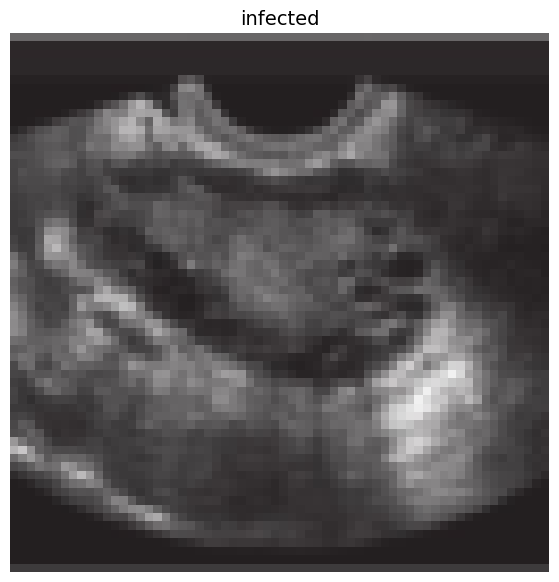

In [200]:
img_permute = img.permute(1, 2, 0)

print(f'Orginal Shape: {img.shape} -> [C, H, W]\nImage Permuted: {img_permute.shape} -> [H, W, C]')

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)
plt.axis(False)

In [201]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                        batch_size = BATCH_SIZE,
                        num_workers=os.cpu_count(),
                        shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a32ef59f010>,
 <torch.utils.data.dataloader.DataLoader at 0x7a32ef59d330>)

In [202]:
len(train_dataloader), len(test_dataloader)

(61, 61)

In [203]:
img, label = next(iter(train_dataloader))

print(f'Image Shape: {img.shape} -> [B, C, H, W]\nLabel Shape: {label.shape}')

Image Shape: torch.Size([32, 3, 64, 64]) -> [B, C, H, W]
Label Shape: torch.Size([32])


In [204]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

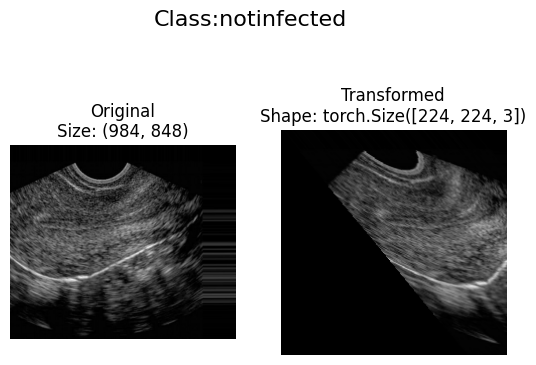

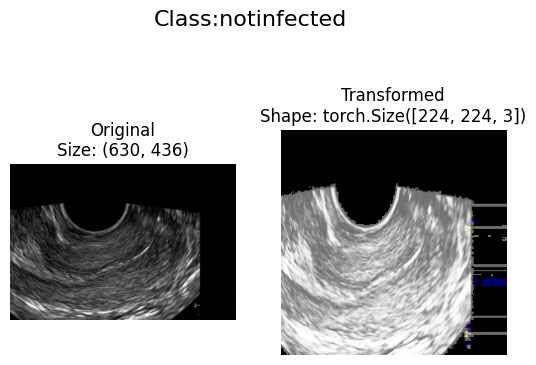

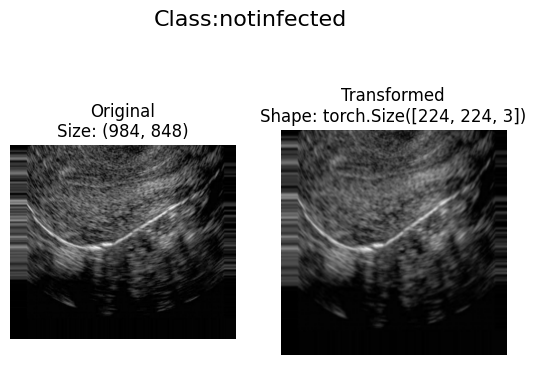

In [205]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

In [206]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [207]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform
)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

In [208]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 13 * 13,
                  out_features = output_shape)
    )

  def forward(self, x):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [213]:
torch.manual_seed(42)

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units= 10,
    output_shape = len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

In [214]:
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [215]:
model_0(image_batch.to(device))

tensor([[0.0045, 0.0109],
        [0.0055, 0.0111],
        [0.0051, 0.0110],
        [0.0044, 0.0093],
        [0.0056, 0.0099],
        [0.0070, 0.0100],
        [0.0060, 0.0106],
        [0.0064, 0.0097],
        [0.0060, 0.0101],
        [0.0053, 0.0106],
        [0.0057, 0.0094],
        [0.0047, 0.0107],
        [0.0045, 0.0101],
        [0.0056, 0.0108],
        [0.0056, 0.0091],
        [0.0035, 0.0102],
        [0.0061, 0.0101],
        [0.0053, 0.0100],
        [0.0066, 0.0091],
        [0.0066, 0.0105],
        [0.0056, 0.0098],
        [0.0059, 0.0112],
        [0.0081, 0.0092],
        [0.0056, 0.0105],
        [0.0042, 0.0108],
        [0.0042, 0.0116],
        [0.0059, 0.0108],
        [0.0051, 0.0105],
        [0.0050, 0.0109],
        [0.0060, 0.0104],
        [0.0051, 0.0098],
        [0.0056, 0.0102]], grad_fn=<AddmmBackward0>)

In [216]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [217]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device = device):

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    #forward pass
    y_pred_logits = model(X)

    #calculate the loss
    loss = loss_fn(y_pred_logits, y)
    train_loss += loss.item()

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    #calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

In [218]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device = device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

  test_loss/=len(dataloader)
  test_acc/=len(dataloader)
  return test_loss, test_acc

In [219]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device = device):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)

  return results

In [221]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# NUM_EPOCHS = 5

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model_0.parameters(),
#                              lr = 0.001)

# from timeit import default_timer as timer
# start_time = timer()

# model_0_results = train(model = model_0,
#                         train_dataloader = train_dataloader_simple,
#                         test_dataloader = test_dataloader_simple,
#                         loss_fn = loss_fn,
#                         optimizer = optimizer,
#                         epochs = NUM_EPOCHS)

# end_time = timer()
# print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 247, in pil_loader
    img = Image.open(f)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='data/images/test/infected/OIP.jpg'>
